In [37]:
import Pkg; Pkg.add("SpecialFunctions")
using SpecialFunctions, Plots
default(size=(480,200))

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


Let's take a [standard](https://erikbern.com/2018/03/27/waiting-time-load-factor-and-queueing-theory.html) [result](https://www.sigarch.org/three-other-models-of-computer-system-performance-part-2) from queueing theory and say that the latency is a function of the load factor, $f$, defined as the ratio of arrival rate to service rate.

$$Latency \propto \frac{1}{1-f}$$

Latencies fly off to infinity when the load factor approaches 1. Makes sense because if the requests arrive faster than they can be serviced then the queue will grow until something else gives.

Now we might assume there is some dispersal in the load factor due to the natural burstiness of incoming traffic. We don't want to model this noise with a normal distribution because our load factor is strictly between 0 and 1. A better choice is the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) which has exactly that property and just so happens to nicely approximate the normal distribution if we [choose the right parameters](https://www.johndcook.com/blog/normal_approx_to_beta/).

Now what happens to the distribution of latencies? Well, luck would have it that the transformation of the beta distribution by the formula above gives us the so called [beta-prime distribution](https://en.wikipedia.org/wiki/Beta_prime_distribution) (up to a constant translation representing the minimum latency). And that approximates a LogNormal distribution surprisingly well, especially around the tail.

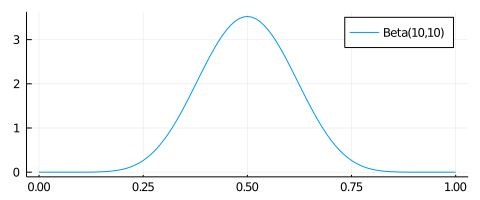

In [38]:
p=10; q=10
betad(x) = (x^(p-1) * (1 - x)^(q-1))/beta(p, q)

plot(0:0.01:1, betad, label="Beta($p,$q)")

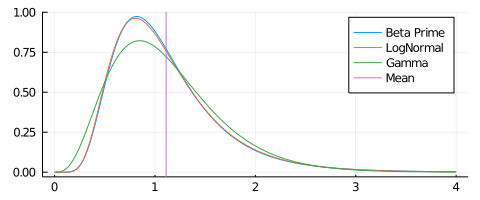

In [39]:
betaprime(x) = (x^(p - 1) * (x + 1)^(-p - q))/beta(p, q)
m=p/(q-1)
v=(p*(p + q - 1))/((q - 2)*(q - 1)^2)

plot(0:0.01:4, ylim=1.0, betaprime, label="Beta Prime")

a = log(m^2/sqrt(v+m^2))
s = sqrt(log((v+m^2)/m^2))
lognormal(x) = (x*s*√(2*π))^-1 * exp(-(log(x) - a)^2/(2s^2))

plot!(0:0.01:4, lognormal, label="LogNormal")

k=m^2/v; l=m/v
gammad(x) = (l^k)*x^(k-1)*exp(-l*x)/gamma(k)

plot!(0:0.01:4, ylim=1.0, gammad, label="Gamma")


vline!([m], label="Mean")


The LogNormal is a good approximation to the BetaPrime for this situation.

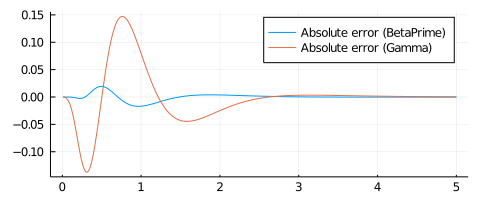

In [40]:
plot(0:0.01:5, x -> lognormal(x)-betaprime(x), label="Absolute error (BetaPrime)")
plot!(0:0.01:5, x -> lognormal(x)-gammad(x), label="Absolute error (Gamma)")

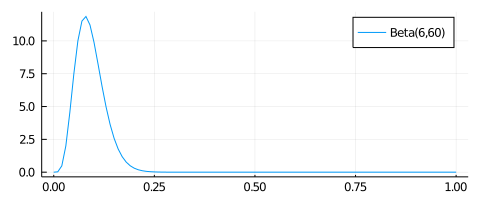

In [41]:
p=6; q=60

plot(0:0.01:1, betad, label="Beta($p,$q)")

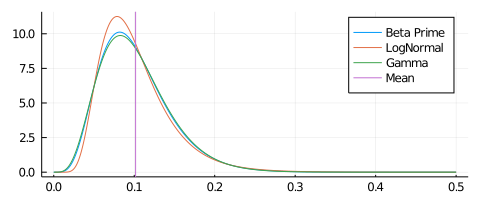

In [42]:
m=p/(q-1)
v=(p*(p + q - 1))/((q - 2)*(q - 1)^2)

plot(0:.001:.5, ylim=1.0, betaprime, label="Beta Prime")

a = log(m^2/sqrt(v+m^2))
s = sqrt(log((v+m^2)/m^2))
lognormal(x) = (x*s*√(2*π))^-1 * exp(-(log(x) - a)^2/(2s^2))

plot!(0:.001:.5, lognormal, label="LogNormal")

k=m^2/v; l=m/v
gammad(x) = (l^k)*x^(k-1)*exp(-l*x)/gamma(k)

plot!(0:.001:.5, ylim=1.0, gammad, label="Gamma")


vline!([m], label="Mean")


Gamma seems to be a better approximatio to the BetaPrime when the load and its variance is lower.

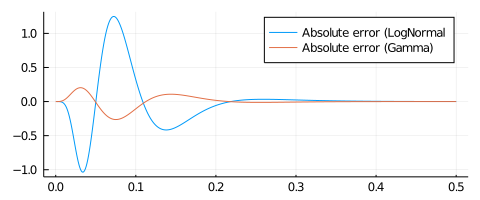

In [43]:
plot(0:.001:.5, x -> lognormal(x)-betaprime(x), label="Absolute error (LogNormal")
plot!(0:.001:.5, x -> gammad(x)-betaprime(x), label="Absolute error (Gamma)")

# Derivation of the transformation of beta distribution to beta prime distribution

We want to apply the transformation $X \rightarrow \frac{1}{1-X}$ to the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). Using the CDF [technique](https://math.stackexchange.com/a/13851) we have:
$$
\begin{align*}
CDF_X(x) & = P(X \leq x) \rightarrow P(\frac{1}{1-X} \leq x) \\
& = P(1 \leq x(1-X)) = P(X \leq \frac{x-1}{x}) \\
& = \frac{1}{B(\alpha,\beta)} \int_{0}^{\frac{x-1}{x}} x^{\alpha-1} (1-x)^{\beta-1} dx
\end{align*}
$$

Differentiating both sides:
$$
\begin{align*}
PDF_X(x) = \frac{d}{dx} CDF_X(x) 
& = \frac{1}{B(\alpha,\beta)} (\frac{x-1}{x})^{\alpha-1} (1-\frac{x-1}{x})^{\beta-1} \frac{d}{dx}(\frac{x-1}{x}) \\
& = \frac{1}{B(\alpha,\beta)} (x-1)^{\alpha-1} x^{1-\alpha} x^{1-\beta} \frac{1}{x^2} \\
& = \frac{1}{B(\alpha,\beta)} (x-1)^{\alpha-1} x^{-\alpha-\beta}
\end{align*}
$$

If we shift the distribution by one (representing the normalised minimum latency, i.e. a fixed service time) then $x \rightarrow x-1$
$$
PDF_X(x) = \frac{1}{B(\alpha,\beta)} x^{\alpha-1} (x+1)^{-\alpha-\beta}
$$
Which is the beta prime distribution.

## Inverse log approximation

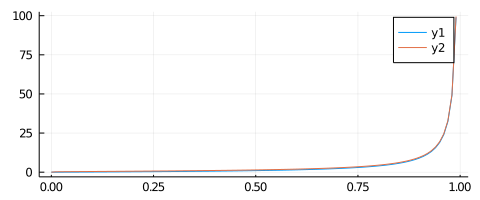

In [44]:
plot(0:0.01:0.99, x -> x/(1-x))

plot!(0:0.01:0.99, x -> -1/log(x))

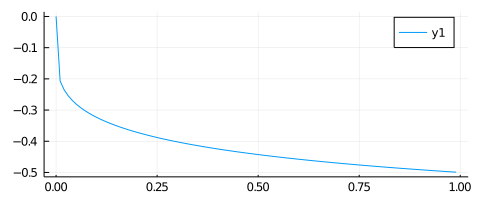

In [45]:
plot(0:0.01:0.99, x -> (x/(1-x) - -1/log(x)))